## Library

In [65]:
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan

import warnings
warnings.simplefilter('ignore')
import seaborn as sns

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None


In [66]:
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

---
"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation parameters

In [67]:
warmup= 5000
samples=20000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

# Clean Data

### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

In [68]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

### Output gap
Beveridge-Nelson Filter's cycle component of GDP in US (https://bnfiltering.com)

In [69]:
# output gap data
data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])


### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)

In [70]:
# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

### The number of Firm  
World Integrated Trade Solution (WITS) of the World Bank
(https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/HH-MKT-CNCNTRTN-NDX#)

quarterly HHI data obtained by linear interpolation of the original annual series

In [71]:
# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["N"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['N'] = data_N['N'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "N"]]
data_N["N"] = (1/data_N["N"]) 
data_N.to_csv("data/N_HHI.csv", index=False)

In [72]:
data_N_hat_annual = pd.read_csv("data/BN_filter_user_inputted_series_results_HHI.csv")
data_N_hat_annual["year"] = (
    pd.to_datetime(data_N_hat_annual["date"])   # ①
      .dt.year                                  # ②
)
data_N_hat_annual['DATE'] = pd.to_datetime(data_N_hat_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_hat_annual = data_N_hat_annual.set_index('DATE')
data_N_hat = data_N_hat_annual.resample('QS').asfreq()
data_N_hat = data_N_hat.reset_index()
data_N_hat['N_hat'] = data_N_hat['cycle'].interpolate(method='linear')
data_N_hat["original_series"] = data_N_hat['original_series'].interpolate(method='linear')
data_N_hat["trend"] = data_N_hat['trend'].interpolate(method='linear')
data_N_hat = data_N_hat[["DATE", "N_hat", "original_series", "trend"]]

## Merge all data

In [73]:
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_N_hat, on="DATE", how="outer")

data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data = data.dropna()
data = data[["DATE","pi", "Epi", "Y", "N", "pi_prev", "Y_prev", "N_hat", "original_series", "trend"]]

# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
Y = jnp.array(data['Y'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Y_prev = jnp.array(data['Y_prev'],dtype=jnp.float64)
N_hat = jnp.array(data["N_hat"], dtype=jnp.float64)

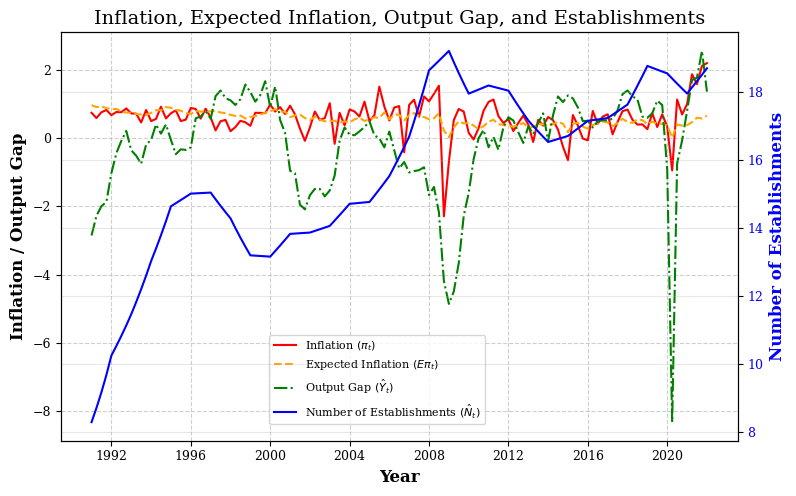

In [74]:
# plot
# --- two-axis version with legend outside ---
fig, ax1 = plt.subplots(figsize=(8, 5))

# left axis
ax1.plot(data["DATE"], data["pi"],  label=r'Inflation $(\pi_{t})$',              color='red')
ax1.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$',   linestyle='--', color='orange')
ax1.plot(data["DATE"], data["Y"],   label=r'Output Gap $(\hat{Y}_{t})$',        linestyle='-.', color='green')
ax1.set_xlabel('Year',  fontsize=12, weight='bold')
ax1.set_ylabel('Inflation / Output Gap', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# right axis
ax2 = ax1.twinx()
ax2.plot(data["DATE"], data["N"],   label=r'Number of Establishments $(\hat{N}_{t})$', color='blue')
ax2.set_ylabel('Number of Establishments', fontsize=12, weight='bold', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# legend outside (right side)
lines  = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels,
           loc='center left',          # anchor to the left-center of bbox
           bbox_to_anchor=(0.3, 0.15), # push legend just outside the axes
           frameon=True, fontsize=8)

ax1.set_title('Inflation, Expected Inflation, Output Gap, and Establishments', fontsize=14)
fig.tight_layout()
plt.show()

## Estimation

# Model
- Note: $\alpha$ + $\beta$ = 1
- Model : NKPC 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t
$$
- Model : HSA
 - observation equation
$$
    \pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t
$$
$$N_{t}=\bar{N}_t+\hat{N}_t$$

 - state equation
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_N \hat{N}_{{t}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}}  + \eta_t
$$
$$\bar{N}_t = \bar{n} + \bar{N}_{{t-1}} + u_t$$
$$\hat{N}_t = \alpha_1 \hat{N}_{{t-1}} +  \alpha_2 \hat{N}_{{t-2}} + v_t$$

$$
\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),  \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

$\pi_{t}$ : Inflation rate = ($\frac{\text{CPI}_{t} - \text{CPI}_{t-1}}{\text{CPI}_{t-1}}$)

$E_t[\hat{\pi}_{t+1}]$ : Quarterly Infration Expectation = $\frac{\text{one year inflation expectation}}{4}$

$\hat{Y}_t$ : Output gap = 100 * cycle of the Real Gross Domestic Product (GDPC1) in US (from BN filter)

$N_{t}$ : the number of establishments = log of (the number of establishments in US * 0.01)


## Extension
- Model : time variant kappa HSA
 - observation equation
$$
    \pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa_{t} \hat{Y}_t - \hat{z}_{t} + \epsilon_t
$$
$$N_{t}=\bar{N}_t+\hat{N}_t$$

 - state equation
$$
\hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_N \hat{N}_{{t}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}}  + \eta_t
$$
$$\bar{N}_t = \bar{n} + \bar{N}_{{t-1}} + u_t$$
$$\hat{N}_t = \alpha_1 \hat{N}_{{t-1}} + \alpha_2 \hat{N}_{{t-2}} + v_t$$
$$\kappa_t = \rho_\kappa \kappa_{{t-1}} + \rho_z z_{{t-1}} + e_t$$
$$
\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),  \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2), \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$


### Prior Distributions

In [75]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "beta"       : dist.Beta(5, 2),
        "kappa"      : dist.Beta(5, 2),
        # State equation (z) params
        "theta_z"    : dist.Beta(5, 2),     # z coeff
        "theta_pi"   : dist.Normal(0, 0.5), # pi coeff
        "theta_N"    : dist.Beta(5, 2),  # N coeff
        "theta_Y"    : dist.Beta(5, 2),  # Y coeff
        # State equation (N) params
        "bar_n"      : dist.Normal(0, 0.05),  # Nbar trend
        "alpha_1"    : dist.Uniform(-1, 1),  # Nhat AR1 coeff
        "alpha_2"    : dist.Uniform(-1, 1),  # Nhat AR1 coeff
        # time variant kappa
        "rho_kappa"  : dist.Uniform(-1, 1),  # kappa AR1 coeff
        "rho_z"      : dist.Uniform(-1, 1),  # kappa AR1 coeff
        # initial
        "z_init"     : dist.Normal(0, 0.5), # z init
        "kappa_init" : dist.Normal(0, 0.5), # kappa init
        # Sigma
        "sigma_eps"  : dist.LogNormal(0,1),   # NKPC error
        "sigma_eta"  : dist.LogNormal(0,1),   # z error
        "sigma_e"    : dist.LogNormal(0,1),   # N error
        "sigma_u"    : dist.LogNormal(0,1),   # Nbar error
        "sigma_v"    : dist.LogNormal(0,1)  # Nhat error
    }
    return priors

$$\hat{\mu}_t = - \frac{1-\rho(z)}{\rho(z)} \hat{z}_t$$
$$\hat{N}_t=-\frac{s'(z) z}{s(z)} \hat{z}_t$$
$\rho(z) < 1$

In [76]:
# Models 
# Normal NKPC
def model_0(pi, pi_prev, pi_expect, Y):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    # model
    pi_pred = alpha * pi_prev + beta * pi_expect + kappa * Y
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi)
    
# Model 1 (BN filter)
def model_1(pi, pi_prev, pi_expect, Y, Y_prev, N_hat, l):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # State equation (z) params
    theta_N = numpyro.sample("theta_N", priors["theta_N"])
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y = numpyro.sample("theta_Y", priors["theta_Y"])
    # Sigma
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])
    # initial 
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        t = carry[1]
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_N * N_hat[t] + theta_z * z_prev + theta_pi * pi_prev[t] + theta_Y * Y_prev[t], sigma_eta))
        z_carry = z
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        return [z_carry, t_carry], None
    scan(transition, [z_init, t], timesteps)


# model 2 (AR 1)
def model_2(pi, pi_prev, pi_expect, Y, Y_prev, N, l):
    priors = set_prior_distributions()
    # NKPC params
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # State equation (z) coefficients
    theta_N = numpyro.sample("theta_N", priors["theta_N"])
    theta_z = numpyro.sample("theta_z", priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y = numpyro.sample("theta_Y", priors["theta_Y"])
    # State equation (N) params
    bar_n    = numpyro.sample("bar_n", priors["bar_n"])      # drift
    alpha_1  = numpyro.sample("alpha_1", priors["alpha_1"])  # cycle AR(1) coefficient
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 1))    # Nhat init
    # Sigma
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      # trend error
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      # cycle error
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) # pi error
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"]) # z error
    # initial 
    z_init = numpyro.sample("z_init", priors["z_init"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        Nbar_prev = carry[1]
        Nhat_prev = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(bar_n + Nbar_prev, sigma_u))
        # cycle：AR(1)
        N_hat_obs = N[t] - Nbar_t
        numpyro.deterministic("Nhat", N_hat_obs)  # for observation
        Nhat_t  = numpyro.sample("Nhat_t", dist.Normal(alpha_1 * Nhat_prev, sigma_v), obs=N_hat_obs)
        # z
        z = numpyro.sample("z", numpyro.distributions.Normal(theta_N * Nhat_t + theta_z * z_prev + theta_pi * pi_prev[t] + theta_Y * Y_prev[t], sigma_eta))
        # observation equation
        # pi
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        # N (Nbar + Nhat = observed N)
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t = t + 1
        return [z, Nbar_t, Nhat_t, t], None
    scan(transition, [z_init, bar_N_0, hat_N_0, t], timesteps)


# Model 3 (AR2)
def model_3(pi, pi_prev, pi_expect, Y, Y_prev, N, l):
    priors = set_prior_distributions()

    # --- NKPC ---
    beta  = numpyro.sample("beta",  priors["beta"])
    alpha = 1.0 - beta
    numpyro.deterministic("alpha", alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])

    # --- z  ---
    theta_N  = numpyro.sample("theta_N",  priors["theta_N"])
    theta_z  = numpyro.sample("theta_z",  priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y  = numpyro.sample("theta_Y",  priors["theta_Y"])

    # --- N trend / cycle ---
    bar_n   = numpyro.sample("bar_n", priors["bar_n"])
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    phi = numpyro.sample("phi", dist.Uniform(0.1, 0.9))  # phi for AR2
    alpha_1 = 2 * r * jnp.cos(jnp.pi * phi)
    alpha_2 = -r ** 2
    numpyro.deterministic("alpha_1", alpha_1) # Nhat AR1 coeff
    numpyro.deterministic("alpha_2", alpha_2) # Nhat AR2 coeff
    # alpha_1 = numpyro.sample("alpha_1", priors["alpha_1"]) # Nhat AR1 coeff
    # alpha_2 = numpyro.sample("alpha_2", priors["alpha_2"]) # Nhat AR2 coeff   
    # --- initials ---
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))  # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 1))    # Nhat init
    hat_N_m1 = numpyro.sample("hat_N_m1", dist.Normal(0, 1))   # t=-1
    z_init   = numpyro.sample("z_init", priors["z_init"])

    # --- variance ---
    sigma_u  = numpyro.sample("sigma_u",  priors["sigma_u"])
    sigma_v  = numpyro.sample("sigma_v",  priors["sigma_v"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])

    # --- carry: (z_{t-1}, bar_N_{t-1}, hat_N_{t-1}, hat_N_{t-2}, t) ---
    def transition(carry, _):
        z_prev, bar_prev, hat_prev1, hat_prev2, t = carry
        # --- trend ---
        Nbar_t = numpyro.sample("Nbar", dist.Normal(bar_prev + bar_n, sigma_u))
        # --- cycle (AR2) ---
        N_hat_obs = N[t] - Nbar_t
        numpyro.deterministic("Nhat", N_hat_obs)  # for observation
        Nhat_t  = numpyro.sample("Nhat_t", dist.Normal(alpha_1 * hat_prev1 + alpha_2 * hat_prev2, sigma_v), obs=N_hat_obs)
        # --- z ---
        z_t = numpyro.sample(
            "z",
            dist.Normal(theta_N * Nhat_t + theta_z * z_prev +
                        theta_pi * pi_prev[t] + theta_Y * Y_prev[t],
                        sigma_eta)
        )
        # --- observation equation ---
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z_t
        numpyro.sample("pi_obs", dist.Normal(pi_pred, sigma_eps), obs=pi[t])
        return (z_t, Nbar_t, Nhat_t, hat_prev1, t + 1), None
    timesteps = jnp.arange(l)
    scan(transition, (z_init, bar_N_0, hat_N_0, hat_N_m1, 0), timesteps)



# Model 4 (time variant kappa)
def model_4(pi, pi_prev, pi_expect, Y, Y_prev, N, l):
    priors = set_prior_distributions()
    # --- NKPC ---
    beta  = numpyro.sample("beta",  priors["beta"])
    alpha = 1.0 - beta
    numpyro.deterministic("alpha", alpha)
    # --- z  ---
    theta_N  = numpyro.sample("theta_N",  priors["theta_N"])
    theta_z  = numpyro.sample("theta_z",  priors["theta_z"])
    theta_pi = numpyro.sample("theta_pi", priors["theta_pi"])
    theta_Y  = numpyro.sample("theta_Y",  priors["theta_Y"])
    # --- kappa ---
    rho_kappa = numpyro.sample("rho_kappa",  priors["rho_kappa"])
    rho_z     = numpyro.sample("rho_z",      priors["rho_z"])
    # --- N trend / cycle ---
    bar_n   = numpyro.sample("bar_n", priors["bar_n"])
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    phi = numpyro.sample("phi", dist.Uniform(0.1, 0.9))  # phi for AR2
    alpha_1 = 2 * r * jnp.cos(jnp.pi * phi)
    alpha_2 = -r ** 2
    numpyro.deterministic("alpha_1", alpha_1) # Nhat AR1 coeff
    numpyro.deterministic("alpha_2", alpha_2) # Nhat AR2 coeff
    # alpha_1 = numpyro.sample("alpha_1", priors["alpha_1"]) # Nhat AR1 coeff
    # alpha_2 = numpyro.sample("alpha_2", priors["alpha_2"]) # Nhat AR2 coeff   
    # --- initials ---
    # initial
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))  # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 1))    # Nhat init
    hat_N_m1 = numpyro.sample("hat_N_m1", dist.Normal(0, 1))   # t=-1
    z_init   = numpyro.sample("z_init", priors["z_init"])
    kappa_init = numpyro.sample("kappa_init", priors["kappa"])
    # --- variance ---
    sigma_u  = numpyro.sample("sigma_u",  priors["sigma_u"])
    sigma_v  = numpyro.sample("sigma_v",  priors["sigma_v"])
    sigma_e = numpyro.sample("sigma_e",  priors["sigma_e"])
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])
    # --- carry: (z_{t-1}, bar_N_{t-1}, hat_N_{t-1}, hat_N_{t-2}, t) ---
    def transition(carry, _):
        z_prev, bar_prev, hat_prev1, hat_prev2, kappa_prev, t = carry
        # --- kappa ---
        kappa = numpyro.sample("kappa", dist.TruncatedNormal(loc=rho_kappa * kappa_prev + rho_z * z_prev, scale=sigma_e, low=0.0))
        # --- trend ---
        Nbar_t = numpyro.sample("Nbar", dist.Normal(bar_prev + bar_n, sigma_u))
        # --- cycle (AR2) ---
        N_hat_obs = N[t] - Nbar_t
        numpyro.deterministic("Nhat", N_hat_obs)  # for observation
        Nhat_t  = numpyro.sample("Nhat_t", dist.Normal(alpha_1 * hat_prev1 + alpha_2 * hat_prev2, sigma_v), obs=N_hat_obs)
        # --- z ---
        z_t = numpyro.sample(
            "z",
            dist.Normal(theta_N * Nhat_t + theta_z * z_prev +
                        theta_pi * pi_prev[t] + theta_Y * Y_prev[t],
                        sigma_eta)
        )
        # --- observation equation ---
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z_t
        numpyro.sample("pi_obs", dist.Normal(pi_pred, sigma_eps), obs=pi[t])
        return (z_t, Nbar_t, Nhat_t, hat_prev1, kappa, t + 1), None
    timesteps = jnp.arange(l)
    scan(transition, (z_init, bar_N_0, hat_N_0, hat_N_m1, kappa_init, 0), timesteps)



In [77]:
# Normal NKPC
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_0 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_kappa = posterior_samples["kappa"].mean()
model_0_alpha = posterior_samples["alpha"].mean()
model_0_beta = posterior_samples["beta"].mean()
diverging  = idata_0.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                           # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")            # bool for each param

sample: 100%|██████████| 25000/25000 [00:03<00:00, 6801.60it/s, 31 steps of size 1.83e-01. acc. prob=1.00]


model 0: divergence ratio = 0.0000%


In [78]:
# HSA NKPC with BN filter
kernel = NUTS(model_1, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, N_hat=N_hat, l=len(pi))
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std_1 = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.97 * z_std_1
z_upper_1 = z_mean_1 + 1.97 * z_std_1  

model_1_alpha = posterior_samples["alpha"].mean()
model_1_kappa = posterior_samples["kappa"].mean()
model_1_beta = posterior_samples["beta"].mean()
model_1_theta_z = posterior_samples["theta_z"].mean()
model_1_theta_Y = posterior_samples["theta_Y"].mean()
model_1_theta_pi = posterior_samples["theta_pi"].mean()
model_1_theta_n = posterior_samples["theta_N"].mean()
diverging  = idata_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")


sample: 100%|██████████| 25000/25000 [00:21<00:00, 1158.78it/s, 127 steps of size 4.29e-02. acc. prob=0.99]


Model 1 : divergence ratio = 0.0000%


In [79]:
# HSA NKPC AR 1
kernel = NUTS(model_2, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,N=N, l=len(pi))
idata_2 = az.from_numpyro(mcmc)

# results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std_2 = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.97 * z_std_2
z_upper_2 = z_mean_2 + 1.97 * z_std_2  

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2 = np.mean(N_bar_samples, axis=0) 
N_bar_std_2 = np.std(N_bar_samples, axis=0)  
N_bar_lower_2 = N_bar_mean_2 - 1.97 * N_bar_std_2
N_bar_upper_2 = N_bar_mean_2 + 1.97 * N_bar_std_2
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2 = np.mean(N_hat_samples, axis=0) 
N_hat_std_2 = np.std(N_hat_samples, axis=0)  
N_hat_lower_2 = N_hat_mean_2 - 1.97 * N_hat_std_2
N_hat_upper_2 = N_hat_mean_2 + 1.97 * N_hat_std_2

model_2_alpha = posterior_samples["alpha"].mean()
model_2_kappa = posterior_samples["kappa"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_theta_z = posterior_samples["theta_z"].mean()
model_2_theta_Y = posterior_samples["theta_Y"].mean()
model_2_theta_pi = posterior_samples["theta_pi"].mean()
model_2_theta_N = posterior_samples["theta_N"].mean()
model_2_alpha_1 = posterior_samples["alpha_1"].mean()
model_2_bar_n = posterior_samples["bar_n"].mean()

diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"model 2: divergence ratio = {ratio_div:.4%}")


sample: 100%|██████████| 25000/25000 [00:43<00:00, 572.12it/s, 63 steps of size 5.42e-02. acc. prob=0.83]  


model 2: divergence ratio = 1.9275%


In [80]:
# HSA NKPC AR 2
# RUN MCMC
kernel = NUTS(model_3, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,N=N, l=len(pi))
idata_3 = az.from_numpyro(mcmc)

# results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std_3 = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.97 * z_std_3
z_upper_3 = z_mean_3 + 1.97 * z_std_3  

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_3 = np.mean(N_bar_samples, axis=0) 
N_bar_std_3 = np.std(N_bar_samples, axis=0)  
N_bar_lower_3 = N_bar_mean_3 - 1.97 * N_bar_std_3
N_bar_upper_3 = N_bar_mean_3 + 1.97 * N_bar_std_3
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_3 = np.mean(N_hat_samples, axis=0) 
N_hat_std_3 = np.std(N_hat_samples, axis=0)  
N_hat_lower_3 = N_hat_mean_3 - 1.97 * N_hat_std_3
N_hat_upper_3 = N_hat_mean_3 + 1.97 * N_hat_std_3

model_3_alpha = posterior_samples["alpha"].mean()
model_3_kappa = posterior_samples["kappa"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_theta_z = posterior_samples["theta_z"].mean()
model_3_theta_Y = posterior_samples["theta_Y"].mean()
model_3_theta_pi = posterior_samples["theta_pi"].mean()
model_3_theta_N = posterior_samples["theta_N"].mean()
model_3_alpha_1 = posterior_samples["alpha_1"].mean()
model_3_alpha_2 = posterior_samples["alpha_2"].mean()
model_3_bar_n = posterior_samples["bar_n"].mean()

diverging  = idata_3.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"model 3: divergence ratio = {ratio_div:.4%}")


sample: 100%|██████████| 25000/25000 [01:21<00:00, 308.07it/s, 255 steps of size 1.70e-02. acc. prob=0.98] 


model 3: divergence ratio = 0.0000%


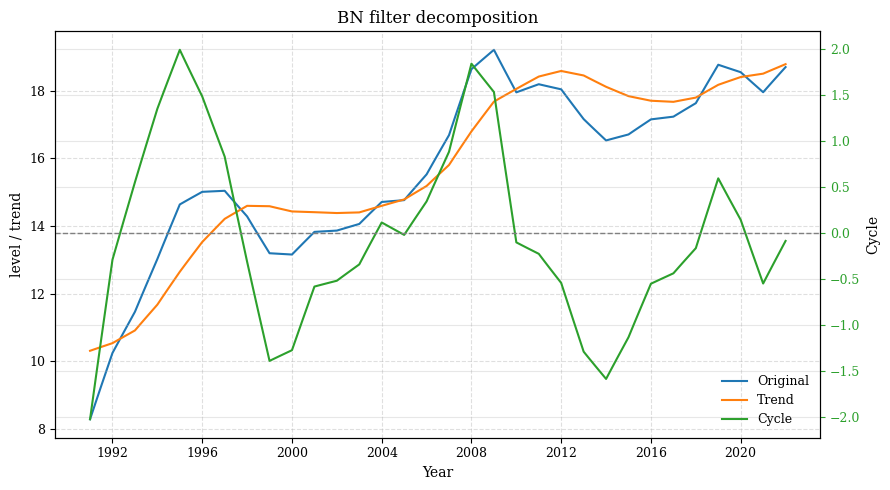

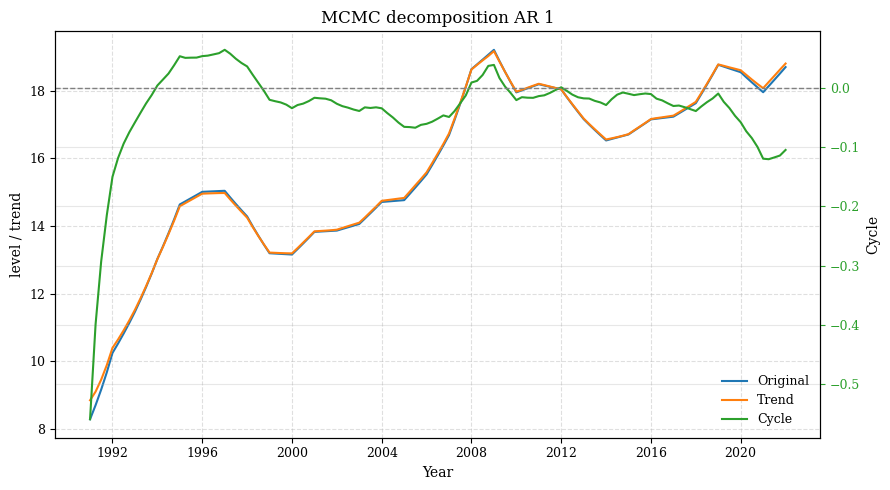

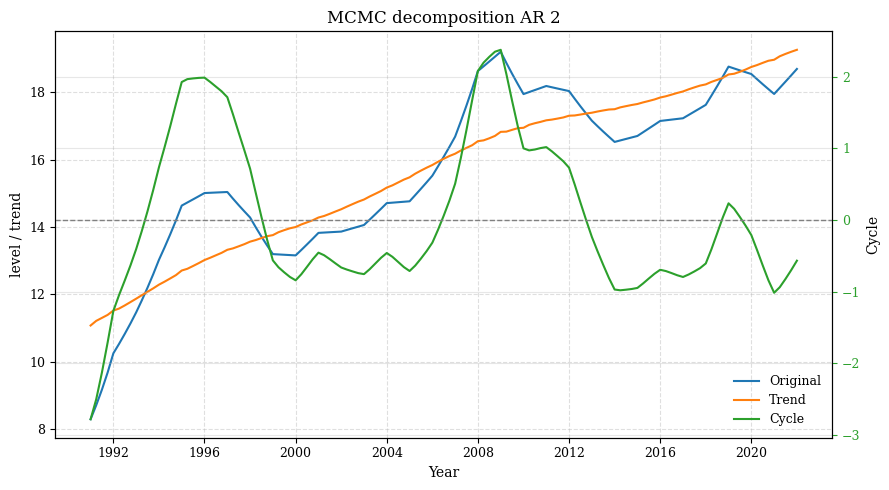

In [81]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

def plot_decomposition(date, original, trend, cycle, title, loc="upper left"):
    scale = 5  # Scale factor for the figure size
    fig, ax1 = plt.subplots(figsize=(1.8*scale, 1*scale)) 

    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # Trend and original
    ax1.plot(date, original, label="Original", color=colors[0])
    ax1.plot(date, trend,    label="Trend",    color=colors[1])
    ax1.set_xlabel("Year")
    ax1.set_ylabel(r"level / trend")

    # Cycle
    ax2 = ax1.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(y=0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # Legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc=loc, frameon=False)

    ax1.set_title(title)
    ax1.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

plot_decomposition(data["DATE"], data["original_series"], data["trend"], data["N_hat"], 
                   "BN filter decomposition", loc="lower right")

plot_decomposition(data["DATE"], N, N_bar_mean_2, N_hat_mean_2, 
                   "MCMC decomposition AR 1", loc="lower right")

plot_decomposition(data["DATE"], N, N_bar_mean_3, N_hat_mean_3, "MCMC decomposition AR 2", loc="lower right")

In [82]:
# def set_prior_distributions():
#     priors = {
#         # NKPC params
#         "beta"       : dist.Beta(5, 2),
#         "kappa"      : dist.Beta(5, 2),
#         # State equation (z) params
#         "theta_z"    : dist.Beta(5, 2), # z coeff
#         "theta_pi"   : dist.Normal(0, 0.5), # pi coeff
#         "theta_N"    : dist.Beta(5, 2), # N coeff
#         "theta_Y"    : dist.Beta(5, 2), # Y coeff
#         # State equation (N) params
#         "bar_n"      : dist.Normal(0, 0.5),  # Nbar trend
#         "alpha_1"    : dist.Uniform(-1, 1),  # Nhat AR1 coeff
#         "alpha_2"    : dist.Uniform(-1, 1),  # Nhat AR1 coeff
#         # time variant kappa
#         "rho_kappa"  :dist.Uniform(-1, 1),  # kappa AR1 coeff
#         "rho_z"  :dist.Uniform(-1, 1),  # kappa AR1 coeff
#         # initial
#         "z_init"     : dist.Normal(0, 0.5), # z init
#         "kappa_init" : dist.Normal(0, 0.5), # kappa init
#         # Sigma
#         "sigma_eps"  : dist.LogNormal(0,1),   # NKPC error
#         "sigma_eta"  : dist.LogNormal(0,1),   # z error
#         "sigma_e"    : dist.LogNormal(0,1),   # N error
#         "sigma_u"    : dist.LogNormal(0,1),   # Nbar error
#         "sigma_v"    : dist.LogNormal(0,1)  # Nhat error
#     }
#     return priors

In [83]:
# HSA NKPC time variant kappa
# RUN MCMC
kernel = NUTS(model_4, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev,N=N, l=len(pi))
idata_4 = az.from_numpyro(mcmc)

# results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_4 = np.mean(z_samples, axis=0) 
z_std_4 = np.std(z_samples, axis=0)  
z_lower_4 = z_mean_4 - 1.97 * z_std_4
z_upper_4 = z_mean_4 + 1.97 * z_std_4  

N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_4 = np.mean(N_bar_samples, axis=0) 
N_bar_std_4 = np.std(N_bar_samples, axis=0)  
N_bar_lower_4 = N_bar_mean_4 - 1.97 * N_bar_std_4
N_bar_upper_4 = N_bar_mean_4 + 1.97 * N_bar_std_4
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_4 = np.mean(N_hat_samples, axis=0) 
N_hat_std_4 = np.std(N_hat_samples, axis=0)  
N_hat_lower_4 = N_hat_mean_4 - 1.97 * N_hat_std_4
N_hat_upper_4 = N_hat_mean_4 + 1.97 * N_hat_std_4

kappa_samples = posterior_samples["kappa"]
kappa_mean_4 = np.mean(kappa_samples, axis=0) 
kappa_std_4 = np.std(kappa_samples, axis=0)  
kappa_lower_4 = kappa_mean_4 - 1.97 * kappa_std_4
kappa_upper_4 = kappa_mean_4 + 1.97 * kappa_std_4

model_4_alpha = posterior_samples["alpha"].mean()
model_4_beta = posterior_samples["beta"].mean()
model_4_theta_z = posterior_samples["theta_z"].mean()
# model_4_theta_Y = posterior_samples["theta_Y"].mean()
# model_4_theta_pi = posterior_samples["theta_pi"].mean()
model_4_theta_N = posterior_samples["theta_N"].mean()
model4_rho_kappa =  posterior_samples["rho_kappa"].mean()
model_4_alpha_1 = posterior_samples["alpha_1"].mean()
model_4_alpha_2 = posterior_samples["alpha_2"].mean()
model_4_bar_n = posterior_samples["bar_n"].mean()

diverging  = idata_4.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"model 4: divergence ratio = {ratio_div:.4%}")

sample: 100%|██████████| 25000/25000 [02:17<00:00, 181.43it/s, 255 steps of size 1.94e-02. acc. prob=0.97]


model 4: divergence ratio = 0.9425%


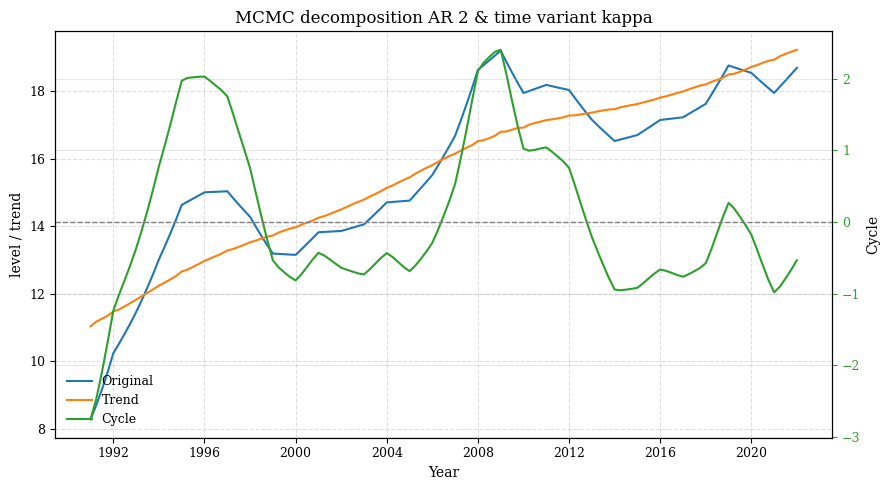

In [84]:
plot_decomposition(data["DATE"], N, N_bar_mean_4, N_hat_mean_4, "MCMC decomposition AR 2 & time variant kappa", loc="lower left")

In [85]:
dict_idata = {'Normal NKPC':idata_0, 'HSA NKPC (AR1)':idata_2,'HSA NKPC (AR2)':idata_3, "HSA NKPC (time variant)" : idata_4}
params = ["alpha","beta", "kappa", "theta_z", "theta_Y", "theta_pi", "theta_N",'bar_n', 'alpha_1', "alpha_2", "rho_kappa", "rho_z", "sigma_eps", "sigma_eta", 'sigma_e' , "sigma_u", "sigma_v"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)


,model,alpha,beta,kappa,theta_z,theta_Y,theta_pi,theta_N,bar_n,alpha_1,alpha_2,rho_kappa,rho_z,sigma_eps,sigma_eta,sigma_e,sigma_u,sigma_v
0,Normal NKPC,0.170,0.830,0.115,-,-,-,-,-,-,-,-,-,0.459,-,-,-,-
1,HSA NKPC (AR1),0.108,0.892,0.218,0.419,0.103,0.024,0.598,0.071,0.704,-,-,-,0.282,0.308,-,0.205,0.044
2,HSA NKPC (AR2),0.104,0.896,0.208,0.405,0.116,-0.002,0.075,0.065,1.759,-0.857,-,-,0.279,0.324,-,0.058,0.125
3,HSA NKPC (time variant),0.101,0.899,-,0.413,0.106,-0.076,0.064,0.065,1.759,-0.858,-0.230,-0.542,0.230,0.231,0.204,0.058,0.126


In [86]:
# tables = {
#     "posterior_means"   : summary_df,
# }

# for name, df in tables.items():
#     latex_code = df.to_latex(index=False, escape=False)
#     display(Markdown(f"### {name}\n```latex\n{latex_code}\n```"))

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

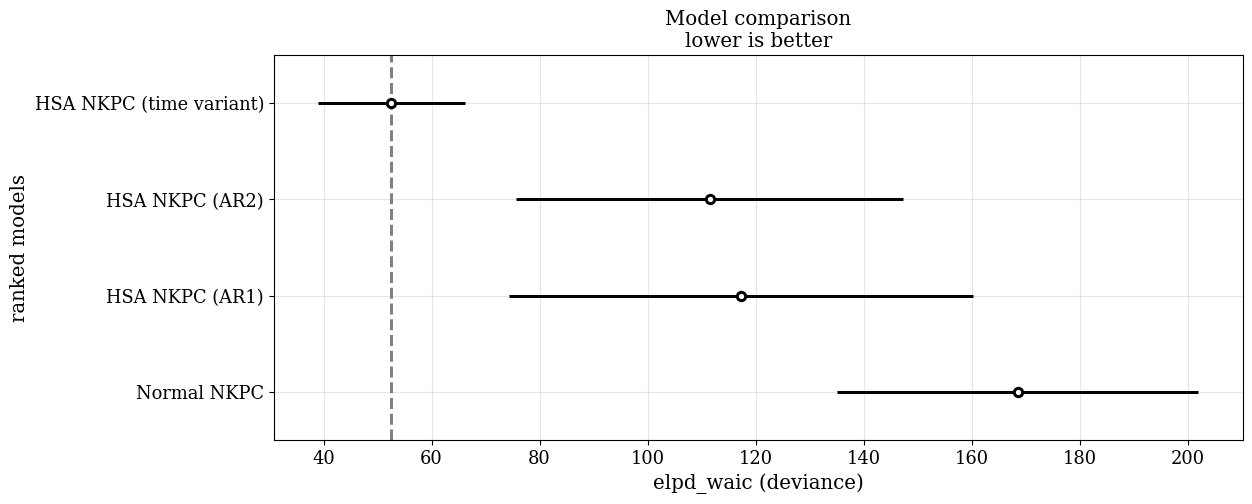

In [87]:
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
scale = 5  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))

# In-sample Fit

In [88]:

var = pd.DataFrame({
    "Variable": ["π", "Yhat", "Nhat", "E[πₜ₊₁]"],
    "Variance": [
        np.var(pi),
        np.var(Y),
        np.var(N_hat),
        np.var(pi_expect)
    ]
})
display(var)

z_data = pd.DataFrame()
z_data["DATE"] = data["DATE"]
z_data["z_mean_2"] = z_mean_1
z_var = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4"],
    "Variance of Z": [
        np.var(z_mean_1),
        np.var(z_mean_2),
        np.var(z_mean_3),
        np.var(z_mean_4),
    ]
})
display(z_var)



coeff_ny = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4"],
    "Cov(Nhat, Y)": [    
        np.corrcoef(N_hat, data["Y"])[0, 1],
        np.corrcoef(N_hat_mean_2, data["Y"])[0, 1],
        np.corrcoef(N_hat_mean_3, data["Y"])[0, 1],
        np.corrcoef(N_hat_mean_4, data["Y"])[0, 1],
    ]
})
display(coeff_ny)


coeff_zY = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4"],
    "Cov(z, Y)": [    
        np.corrcoef(z_mean_1, data["Y"])[0, 1],
        np.corrcoef(z_mean_2, data["Y"])[0, 1],
        np.corrcoef(z_mean_3, data["Y"])[0, 1],
        np.corrcoef(z_mean_4, data["Y"])[0, 1],
    ]
})
display(coeff_zY)

coeff_zN = pd.DataFrame({
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4"],
    "Cov(z, Nhat)": [    
        np.corrcoef(z_mean_1, N_hat)[0, 1],
        np.corrcoef(z_mean_2, N_hat_mean_2)[0, 1],
        np.corrcoef(z_mean_3, N_hat_mean_3)[0, 1],
        np.corrcoef(z_mean_4, N_hat_mean_4)[0, 1],
    ]
})
display(coeff_zN)


,Variable,Variance
0,π,0.2778803
1,Yhat,2.1890771
2,Nhat,0.8692643
3,E[πₜ₊₁],0.03529018


,Model,Variance of Z
0,Model 1,0.1207072
1,Model 2,0.11823417
2,Model 3,0.11670079
3,Model 4,0.07566426


,Model,"Cov(Nhat, Y)"
0,Model 1,-0.252647
1,Model 2,0.188422
2,Model 3,-0.183459
3,Model 4,-0.182004


,Model,"Cov(z, Y)"
0,Model 1,0.460448
1,Model 2,0.517780
2,Model 3,0.474435
3,Model 4,0.517884


,Model,"Cov(z, Nhat)"
0,Model 1,-0.123953
1,Model 2,0.321683
2,Model 3,0.025245
3,Model 4,0.078756


In [89]:
# tables = {
#     "posterior_means"   : summary_df,
#     "variance_core"     : var,
#     "variance_z"        : z_var,
#     "corr_NY"           : coeff,
#     "corr_zY"           : coeff_zY,
#     "corr_zN"           : coeff_zN,
#     "loo_compare_dev"   : df_loo_dev
# }

# for name, df in tables.items():
#     latex_code = df.to_latex(index=False, escape=False)
#     display(Markdown(f"### {name}\n```latex\n{latex_code}\n```"))

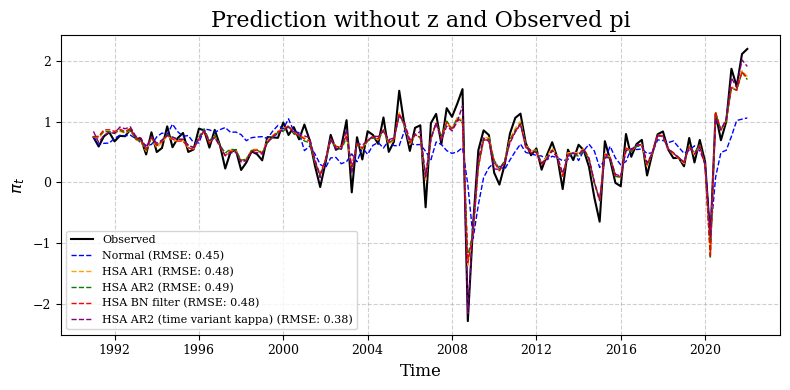

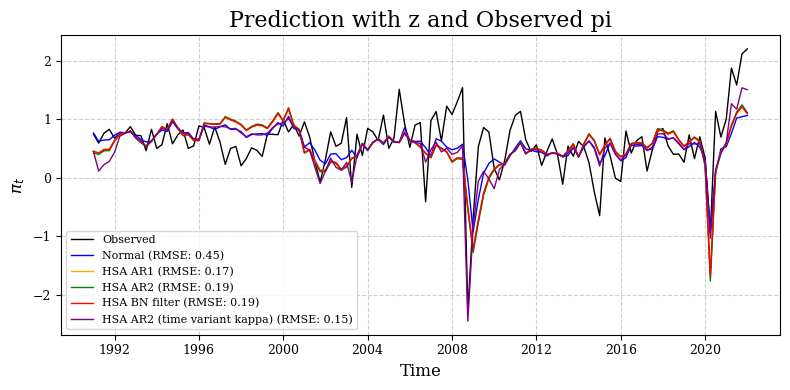

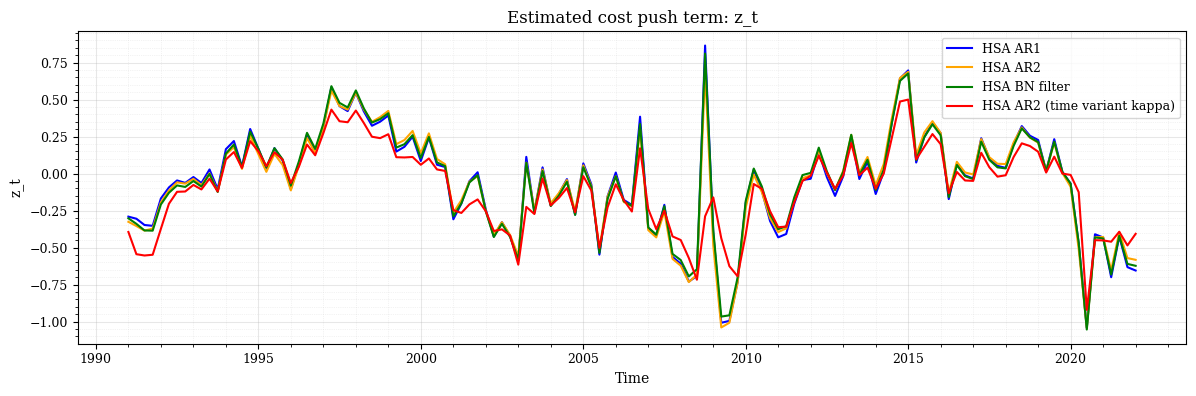

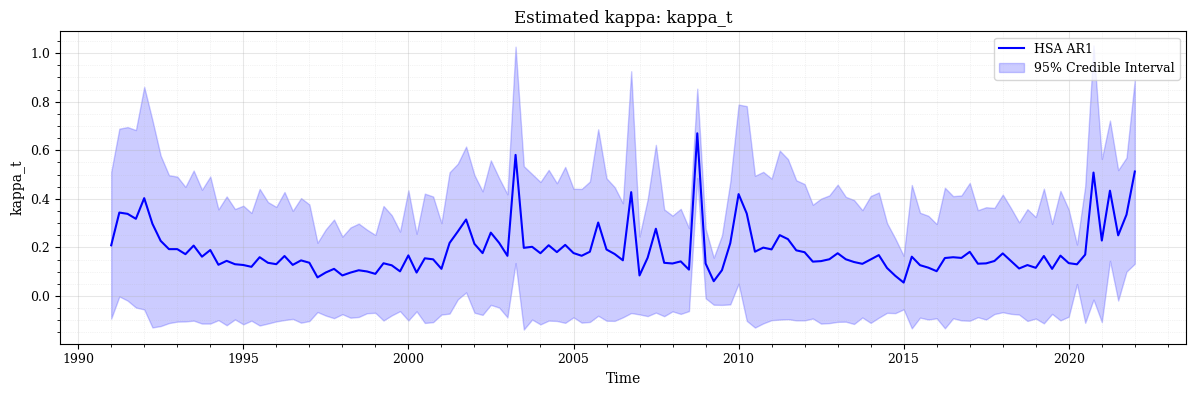

In [90]:
pi_pred_0 = model_0_alpha * data["pi_prev"] + model_0_beta * data["Epi"] + model_0_kappa * data["Y"]
pi_pred_1 = model_1_alpha * data["pi_prev"] + model_1_beta * data["Epi"] + model_1_kappa * data["Y"]
pi_pred_2 = model_2_alpha * data["pi_prev"] + model_2_beta * data["Epi"] + model_2_kappa * data["Y"]
pi_pred_3 = model_3_alpha * data["pi_prev"] + model_3_beta * data["Epi"] + model_3_kappa * data["Y"]
pi_pred_4 = model_4_alpha * data["pi_prev"] + model_4_beta * data["Epi"] + kappa_mean_4 * data["Y"]
pi_pred_1_z = model_1_alpha * data["pi_prev"] + model_1_beta * data["Epi"] + model_1_kappa * data["Y"] - z_mean_1
pi_pred_2_z = model_2_alpha * data["pi_prev"] + model_2_beta * data["Epi"] + model_2_kappa * data["Y"] - z_mean_2
pi_pred_3_z = model_3_alpha * data["pi_prev"] + model_3_beta * data["Epi"] + model_3_kappa * data["Y"] - z_mean_3
pi_pred_4_z = model_4_alpha * data["pi_prev"] + model_4_beta * data["Epi"] + kappa_mean_4 * data["Y"] - z_mean_4

obs = data["pi"]

def get_scores(y_true, y_pred):
    e = y_true - y_pred
    rmse = np.sqrt(np.mean(e ** 2))
    mae = np.mean(np.abs(e))
    return rmse, mae

scores = {
    "Model 0": get_scores(obs, pi_pred_0),
    "Model 1": get_scores(obs, pi_pred_1),
    "Model 2": get_scores(obs, pi_pred_2),
    "Model 3": get_scores(obs, pi_pred_3),
    "Model 4": get_scores(obs, pi_pred_4),
    }

# plot
title = "Prediction without z and Observed pi"
plt.figure(figsize=(8, 4))
plt.plot(data["DATE"], obs, label="Observed", color=colors[0], linestyle='-', linewidth=1.5)
plt.plot(data["DATE"], pi_pred_0, label=f"Normal (RMSE: {scores['Model 0'][0]:.2f})", 
         color=colors[1], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_1_z, label=f"HSA AR1 (RMSE: {scores['Model 1'][0]:.2f})", 
         color=colors[2], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_2_z, label=f"HSA AR2 (RMSE: {scores['Model 2'][0]:.2f})",
         color=colors[3], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_3_z , label=f"HSA BN filter (RMSE: {scores['Model 3'][0]:.2f})",
         color=colors[4], linestyle='--', linewidth=1)
plt.plot(data["DATE"], pi_pred_4_z, label=f"HSA AR2 (time variant kappa) (RMSE: {scores['Model 4'][0]:.2f})",
         color=colors[5], linestyle='--', linewidth=1)

plt.title(title, fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$\pi_t$", fontsize=12)
plt.legend(loc='lower left', fontsize=8, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


scores = {
    "Model 0": get_scores(obs, pi_pred_0),
    "Model 1": get_scores(obs, pi_pred_1_z),
    "Model 2": get_scores(obs, pi_pred_2_z),
    "Model 3": get_scores(obs, pi_pred_3_z),
    "Model 4": get_scores(obs, pi_pred_4_z),
    }

plt.figure(figsize=(8, 4))
title = "Prediction with z and Observed pi"
plt.plot(data["DATE"], obs, label="Observed", color=colors[0], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_0, label=f"Normal (RMSE: {scores['Model 0'][0]:.2f})", 
         color=colors[1], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_1, label=f"HSA AR1 (RMSE: {scores['Model 1'][0]:.2f})", 
         color=colors[2], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_2, label=f"HSA AR2 (RMSE: {scores['Model 3'][0]:.2f})",
         color=colors[3], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_3, label=f"HSA BN filter (RMSE: {scores['Model 2'][0]:.2f})",
         color=colors[4], linestyle='-', linewidth=1)
plt.plot(data["DATE"], pi_pred_4, label=f"HSA AR2 (time variant kappa) (RMSE: {scores['Model 4'][0]:.2f})",
         color=colors[5], linestyle='-', linewidth=1)

plt.title(title, fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel(r"$\pi_t$", fontsize=12)
plt.legend(loc='lower left', fontsize=8, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.rcParams.update({'font.size': 8}) 
import matplotlib.dates as mdates
# print(f"Bayesian R^2: {r2}")

plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], z_mean_1, label="HSA AR1", color=colors[1])
# plt.fill_between(data["DATE"], z_lower_1, z_upper_1, color=colors[1], alpha=0.2, label="95% Credible Interval")
plt.plot(data["DATE"], z_mean_2, label="HSA AR2", color=colors[2])
# plt.fill_between(data["DATE"], z_lower_2, z_upper_2, color=colors[2], alpha=0.2, label="95% Credible Interval")
plt.plot(data["DATE"], z_mean_3, label="HSA BN filter", color=colors[3])
# plt.fill_between(data["DATE"], z_lower_3, z_upper_3, color=colors[3], alpha=0.2, label="95% Credible Interval")
plt.plot(data["DATE"], z_mean_4, label="HSA AR2 (time variant kappa)", color=colors[4])
# plt.fill_between(data["DATE"], z_lower_4, z_upper_4, color=colors[4], alpha=0.2, label="95% Credible Interval") 
plt.title("Estimated cost push term: z_t")
plt.xlabel("Time")
plt.ylabel("z_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_4, label="HSA AR1", color=colors[1])
plt.fill_between(data["DATE"], kappa_lower_4, kappa_upper_4, color=colors[1], alpha=0.2, label="95% Credible Interval")
plt.title("Estimated kappa: kappa_t")
plt.xlabel("Time")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()


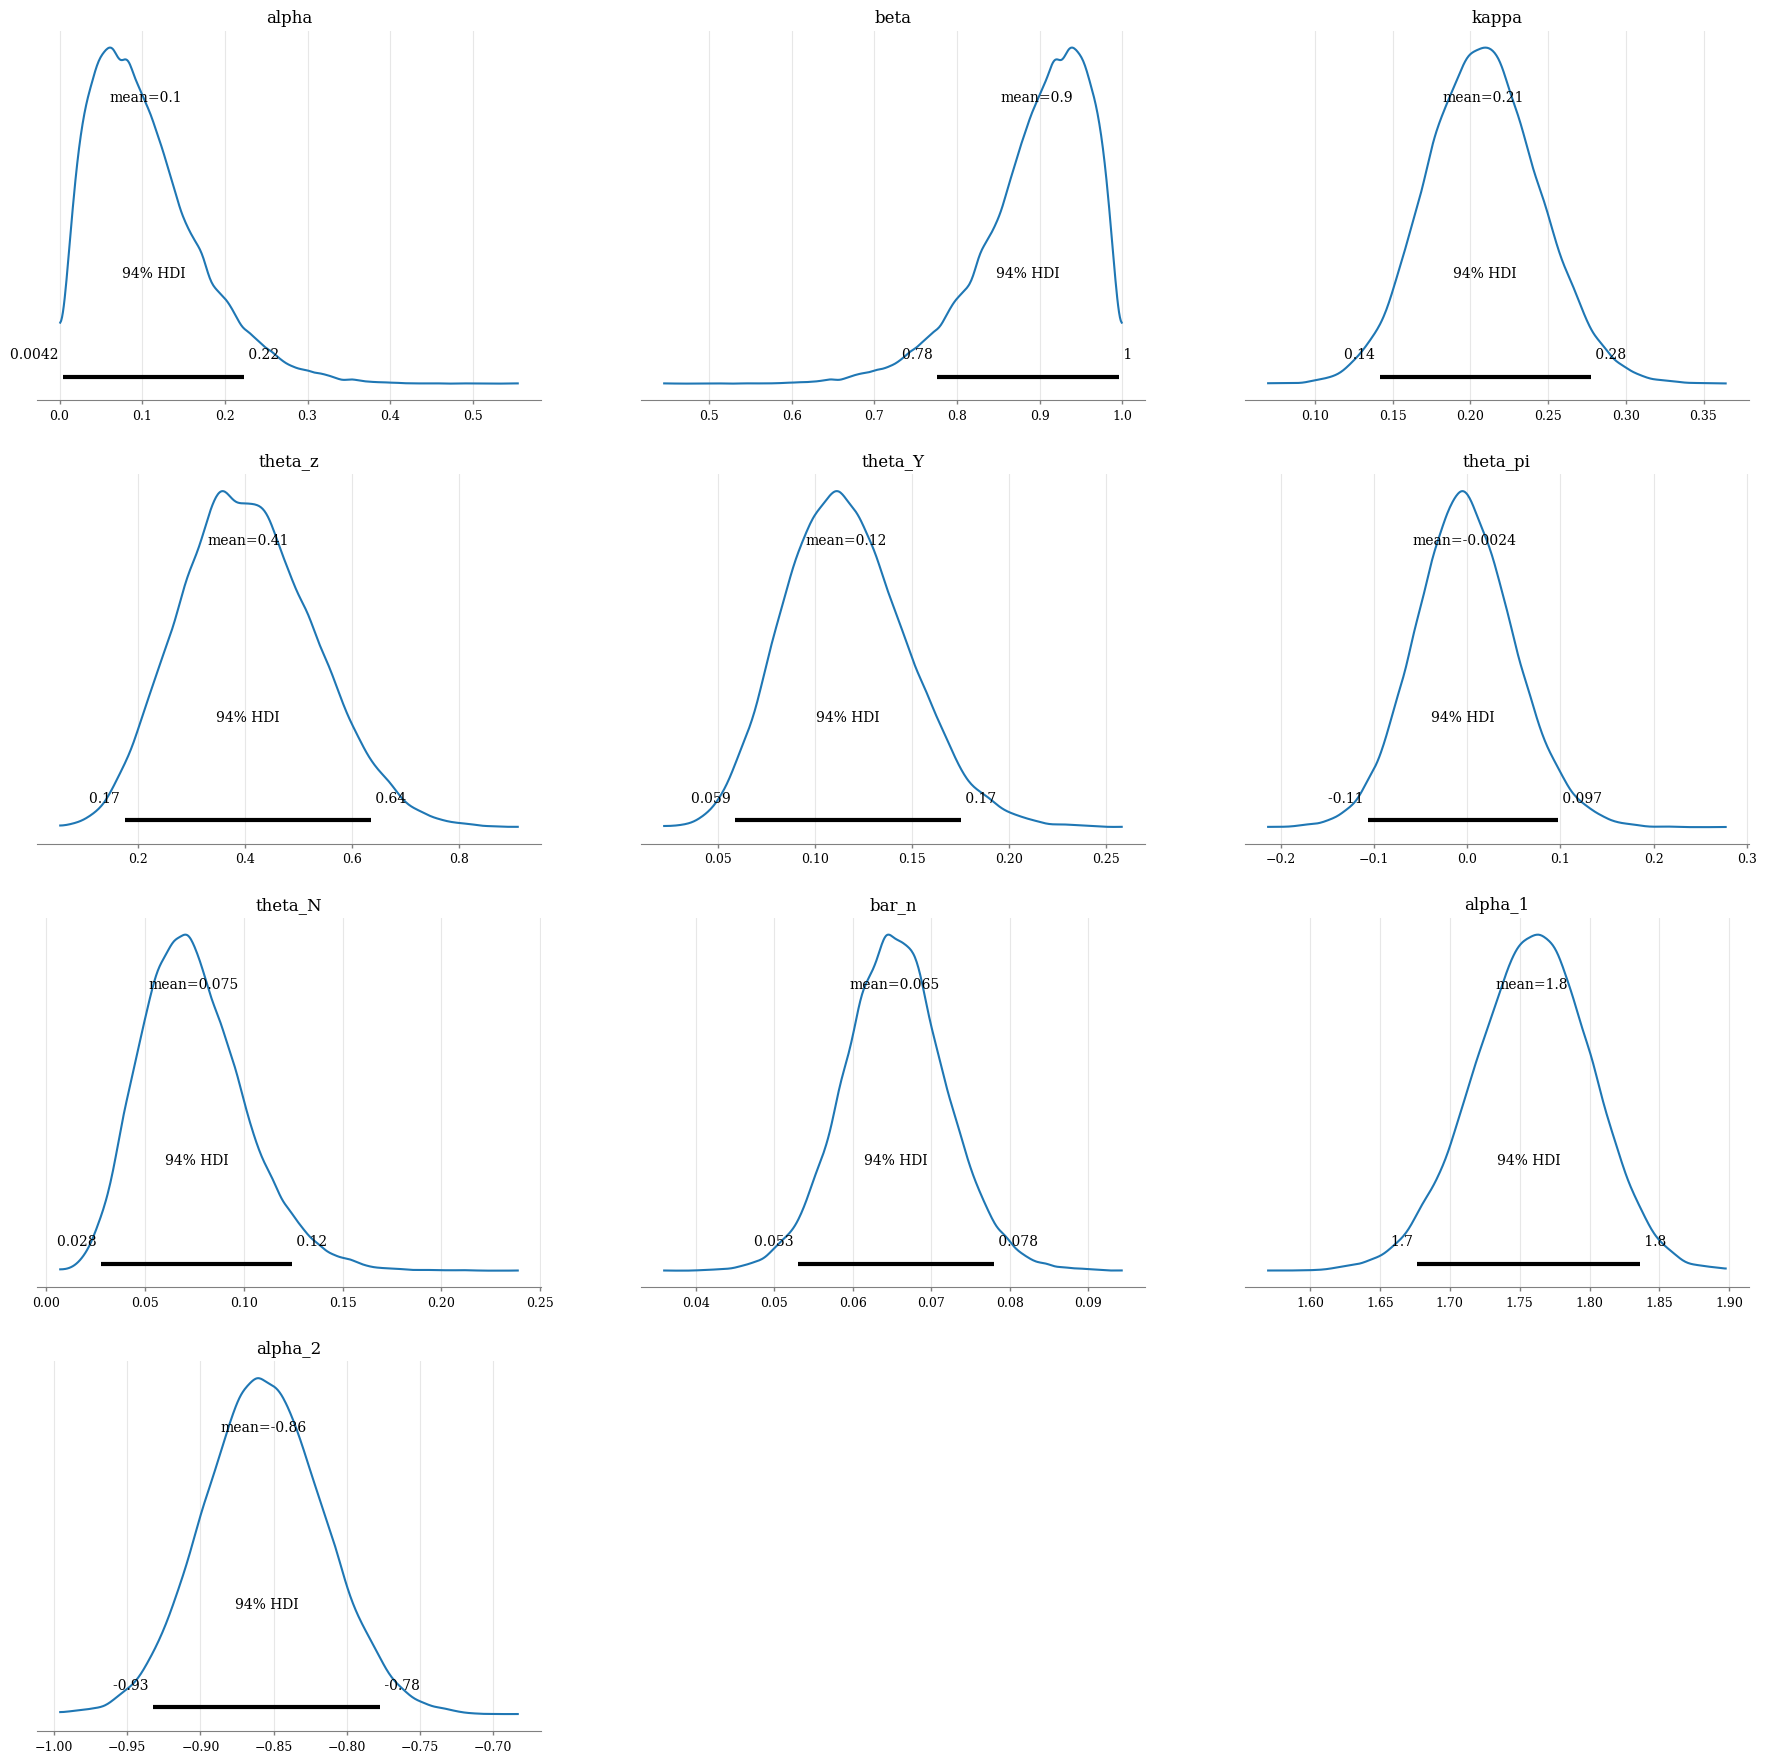

In [91]:
az.plot_posterior(idata_3, var_names=["alpha", "beta", "kappa", "theta_z", "theta_Y", "theta_pi", "theta_N", "bar_n", "alpha_1","alpha_2"],)
plt.show()

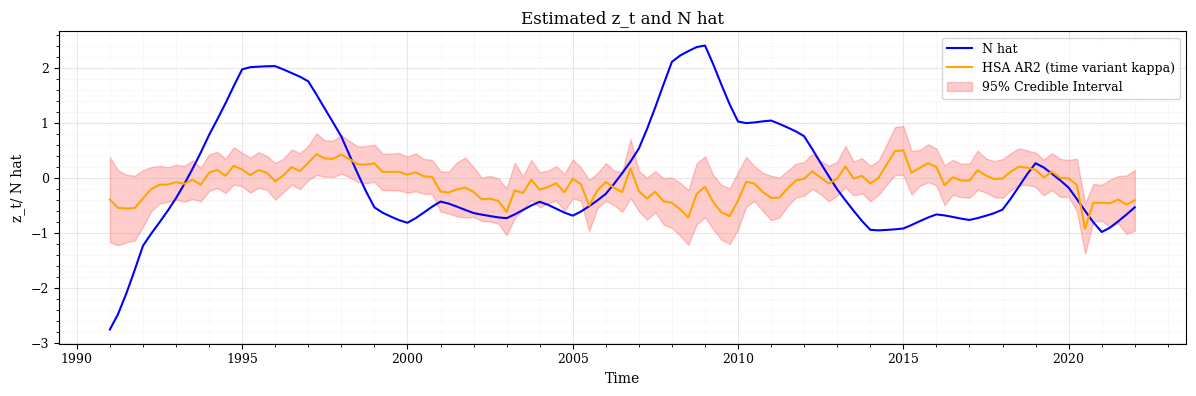

In [93]:
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], N_hat_mean_4, label="N hat", color=colors[1])
plt.plot(data["DATE"], z_mean_4, label="HSA AR2 (time variant kappa)", color=colors[2])
plt.fill_between(data["DATE"], z_lower_4, z_upper_4, color=colors[4], alpha=0.2, label="95% Credible Interval") 
plt.title("Estimated z_t and N hat")
plt.xlabel("Time")
plt.ylabel("z_t/ N hat")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()